In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt

import gym

import random

from collections import namedtuple

from itertools import count

%matplotlib inline

In [2]:
import warnings
warnings.simplefilter("error")
warnings.simplefilter("ignore", UserWarning)

In [3]:
torch.manual_seed(1)
np.random.seed(1)

In [4]:
env_name = "CartPole-v0"
env = gym.make(env_name)
env.seed(1)

[1]

In [5]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [6]:
TARGET_UPDATE = 10
glie_a = 5
num_episodes = 10000
hidden = 256
gamma = 0.999
replay_buffer_size = 10000
batch_size = 128
eps_stop = 0.05

In [7]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'done'))


class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


In [8]:
class DQN(nn.Module):
    def __init__(self, state_space_dim, action_space_dim, hidden=12):
        super(DQN, self).__init__()
        self.hidden = hidden
        self.fc1 = nn.Linear(state_space_dim, hidden)
        self.fc2 = nn.Linear(hidden, hidden//2)
        self.fc3 = nn.Linear(hidden//2, action_space_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

In [9]:
class DQNAgent(object):
    def __init__(self, state_space, n_actions, replay_buffer_size=50000,
                 batch_size=32, hidden_size=12, gamma=0.98):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.n_actions = n_actions
        self.state_space_dim = state_space
        self.policy_net = DQN(state_space, n_actions, hidden_size).to(self.device)
        self.target_net = DQN(state_space, n_actions, hidden_size).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=1e-3)
        self.memory = ReplayMemory(replay_buffer_size)
        self.batch_size = batch_size
        self.gamma = gamma

    def update_network(self, updates=1):
        for _ in range(updates):
            self._do_network_update()

    def _do_network_update(self):
        if len(self.memory) < self.batch_size:
            return
        transitions = self.memory.sample(self.batch_size)
        # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
        # detailed explanation). This converts batch-array of Transitions
        # to Transition of batch-arrays.
        batch = Transition(*zip(*transitions))

        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        non_final_mask = 1 - torch.tensor(batch.done, dtype=torch.uint8)
        non_final_next_states = [s for nonfinal,s in zip(non_final_mask,
                                     batch.next_state) if nonfinal > 0]
        non_final_next_states = torch.stack(non_final_next_states).to(self.device)
        state_batch = torch.stack(batch.state).to(self.device)
        action_batch = torch.cat(batch.action).to(self.device)
        reward_batch = torch.cat(batch.reward).to(self.device)

        self.optimizer.zero_grad()
        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        state_action_values = self.policy_net(state_batch).gather(1, action_batch)
        
        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1)[0].
        # This is merged based on the mask, such that we'll have either the expected
        # state value or 0 in case the state was final.
        # about detach(): https://discuss.pytorch.org/t/detach-no-grad-and-requires-grad/16915/7
        next_state_values = torch.zeros(self.batch_size).to(self.device)
        next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0].detach()
        expected_state_action_values = reward_batch + self.gamma * next_state_values
        
        # Compute Huber loss
        loss = F.smooth_l1_loss(state_action_values.squeeze(),
                                expected_state_action_values)

        # Optimize the model
        loss.backward()
        for param in self.policy_net.parameters():
            param.grad.data.clamp_(-1e-1, 1e-1)
        self.optimizer.step()

    def get_action(self, state, epsilon=0.05):
        sample = random.random()
        if sample > epsilon:
            with torch.no_grad():
                state = torch.from_numpy(state).float().to(self.device)
                q_values = self.policy_net(state).to(self.device)
                return torch.argmax(q_values).item()
        else:
            return random.randrange(self.n_actions)

    def update_target_network(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

    def store_transition(self, state, action, next_state, reward, done):
        action = torch.Tensor([[action]]).long()
        reward = torch.tensor([reward], dtype=torch.float32)
        next_state = torch.from_numpy(next_state).float()
        state = torch.from_numpy(state).float()
        self.memory.push(state, action, next_state, reward, done)


In [10]:
def plot_rewards(rewards):
    plt.figure(2)
    plt.clf()
    rewards_t = torch.tensor(rewards, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Cumulative reward')
    plt.grid(True)
    plt.plot(rewards_t.numpy())
    # Take 100 episode averages and plot them too
    if len(rewards_t) >= 100:
        means = rewards_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())


In [11]:
# Get number of actions from gym action space
n_actions = env.action_space.n
state_space_dim = env.observation_space.shape[0]

agent = DQNAgent(state_space_dim, n_actions, replay_buffer_size, batch_size,
                  hidden, gamma)

print('agent policy net: ', agent.policy_net)

agent policy net:  DQN(
  (fc1): Linear(in_features=4, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=2, bias=True)
)


In [12]:
# Training loop
cumulative_rewards = []
for ep in range(num_episodes):
    # Initialize the environment and state
    print('training started ...')
    state = env.reset()
    done = False
    eps = max(eps_stop , glie_a/(glie_a+ep))
    cum_reward = 0
    while not done:
        # Select and perform an action
        action = agent.get_action(state, eps)
        next_state, reward, done, _ = env.step(action)
        cum_reward += reward

        agent.store_transition(state, action, next_state, reward, done)
        agent.update_network()

        # Move to the next state
        state = next_state

    cumulative_rewards.append(cum_reward)

    print("episode: %d: reward: %6.2f, mean_100: %6.2f, epsilon: %.2f" % (
        ep, cum_reward, np.mean(cumulative_rewards[-100:]), eps))

    if np.mean(cumulative_rewards[-100:]) > 195.0:
        print("Solved in ep : {} and break".format(ep))
        break

    # Update the target network, copying all weights and biases in DQN
    if ep % TARGET_UPDATE == 0:
        agent.update_target_network()


print('Complete')


training started ...
episode: 0: reward:  14.00, mean_100:  14.00, epsilon: 1.00
training started ...
episode: 1: reward:  40.00, mean_100:  27.00, epsilon: 0.83
training started ...
episode: 2: reward:  10.00, mean_100:  21.33, epsilon: 0.71
training started ...
episode: 3: reward:  15.00, mean_100:  19.75, epsilon: 0.62
training started ...
episode: 4: reward:  14.00, mean_100:  18.60, epsilon: 0.56
training started ...
episode: 5: reward:  27.00, mean_100:  20.00, epsilon: 0.50
training started ...
episode: 6: reward:  23.00, mean_100:  20.43, epsilon: 0.45
training started ...
episode: 7: reward:  10.00, mean_100:  19.12, epsilon: 0.42
training started ...
episode: 8: reward:  10.00, mean_100:  18.11, epsilon: 0.38
training started ...
episode: 9: reward:  12.00, mean_100:  17.50, epsilon: 0.36
training started ...
episode: 10: reward:  18.00, mean_100:  17.55, epsilon: 0.33
training started ...
episode: 11: reward:  12.00, mean_100:  17.08, epsilon: 0.31
training started ...
episo

episode: 100: reward: 200.00, mean_100:  93.76, epsilon: 0.05
training started ...
episode: 101: reward: 200.00, mean_100:  95.36, epsilon: 0.05
training started ...
episode: 102: reward: 200.00, mean_100:  97.26, epsilon: 0.05
training started ...
episode: 103: reward: 200.00, mean_100:  99.11, epsilon: 0.05
training started ...
episode: 104: reward: 200.00, mean_100: 100.97, epsilon: 0.05
training started ...
episode: 105: reward: 200.00, mean_100: 102.70, epsilon: 0.05
training started ...
episode: 106: reward: 200.00, mean_100: 104.47, epsilon: 0.05
training started ...
episode: 107: reward: 200.00, mean_100: 106.37, epsilon: 0.05
training started ...
episode: 108: reward: 200.00, mean_100: 108.27, epsilon: 0.05
training started ...
episode: 109: reward: 200.00, mean_100: 110.15, epsilon: 0.05
training started ...
episode: 110: reward: 200.00, mean_100: 111.97, epsilon: 0.05
training started ...
episode: 111: reward: 200.00, mean_100: 113.85, epsilon: 0.05
training started ...
epis

episode: 199: reward: 200.00, mean_100: 188.45, epsilon: 0.05
training started ...
episode: 200: reward: 200.00, mean_100: 188.45, epsilon: 0.05
training started ...
episode: 201: reward:  46.00, mean_100: 186.91, epsilon: 0.05
training started ...
episode: 202: reward: 168.00, mean_100: 186.59, epsilon: 0.05
training started ...
episode: 203: reward: 136.00, mean_100: 185.95, epsilon: 0.05
training started ...
episode: 204: reward: 175.00, mean_100: 185.70, epsilon: 0.05
training started ...
episode: 205: reward: 145.00, mean_100: 185.15, epsilon: 0.05
training started ...
episode: 206: reward: 141.00, mean_100: 184.56, epsilon: 0.05
training started ...
episode: 207: reward: 161.00, mean_100: 184.17, epsilon: 0.05
training started ...
episode: 208: reward: 153.00, mean_100: 183.70, epsilon: 0.05
training started ...
episode: 209: reward: 143.00, mean_100: 183.13, epsilon: 0.05
training started ...
episode: 210: reward: 168.00, mean_100: 182.81, epsilon: 0.05
training started ...
epis

episode: 298: reward: 191.00, mean_100: 166.62, epsilon: 0.05
training started ...
episode: 299: reward: 197.00, mean_100: 166.59, epsilon: 0.05
training started ...
episode: 300: reward: 200.00, mean_100: 166.59, epsilon: 0.05
training started ...
episode: 301: reward: 200.00, mean_100: 168.13, epsilon: 0.05
training started ...
episode: 302: reward: 200.00, mean_100: 168.45, epsilon: 0.05
training started ...
episode: 303: reward: 199.00, mean_100: 169.08, epsilon: 0.05
training started ...
episode: 304: reward: 200.00, mean_100: 169.33, epsilon: 0.05
training started ...
episode: 305: reward: 183.00, mean_100: 169.71, epsilon: 0.05
training started ...
episode: 306: reward: 169.00, mean_100: 169.99, epsilon: 0.05
training started ...
episode: 307: reward: 188.00, mean_100: 170.26, epsilon: 0.05
training started ...
episode: 308: reward: 171.00, mean_100: 170.44, epsilon: 0.05
training started ...
episode: 309: reward: 192.00, mean_100: 170.93, epsilon: 0.05
training started ...
epis

episode: 397: reward:  92.00, mean_100: 154.56, epsilon: 0.05
training started ...
episode: 398: reward: 160.00, mean_100: 154.25, epsilon: 0.05
training started ...
episode: 399: reward: 200.00, mean_100: 154.28, epsilon: 0.05
training started ...
episode: 400: reward: 200.00, mean_100: 154.28, epsilon: 0.05
training started ...
episode: 401: reward: 200.00, mean_100: 154.28, epsilon: 0.05
training started ...
episode: 402: reward: 200.00, mean_100: 154.28, epsilon: 0.05
training started ...
episode: 403: reward: 200.00, mean_100: 154.29, epsilon: 0.05
training started ...
episode: 404: reward: 200.00, mean_100: 154.29, epsilon: 0.05
training started ...
episode: 405: reward: 200.00, mean_100: 154.46, epsilon: 0.05
training started ...
episode: 406: reward: 200.00, mean_100: 154.77, epsilon: 0.05
training started ...
episode: 407: reward: 200.00, mean_100: 154.89, epsilon: 0.05
training started ...
episode: 408: reward: 200.00, mean_100: 155.18, epsilon: 0.05
training started ...
epis

episode: 496: reward: 200.00, mean_100: 172.15, epsilon: 0.05
training started ...
episode: 497: reward:  69.00, mean_100: 171.92, epsilon: 0.05
training started ...
episode: 498: reward:  70.00, mean_100: 171.02, epsilon: 0.05
training started ...
episode: 499: reward: 200.00, mean_100: 171.02, epsilon: 0.05
training started ...
episode: 500: reward: 200.00, mean_100: 171.02, epsilon: 0.05
training started ...
episode: 501: reward:  21.00, mean_100: 169.23, epsilon: 0.05
training started ...
episode: 502: reward:  74.00, mean_100: 167.97, epsilon: 0.05
training started ...
episode: 503: reward:  26.00, mean_100: 166.23, epsilon: 0.05
training started ...
episode: 504: reward: 200.00, mean_100: 166.23, epsilon: 0.05
training started ...
episode: 505: reward: 200.00, mean_100: 166.23, epsilon: 0.05
training started ...
episode: 506: reward:  53.00, mean_100: 164.76, epsilon: 0.05
training started ...
episode: 507: reward:  62.00, mean_100: 163.38, epsilon: 0.05
training started ...
epis

episode: 595: reward: 102.00, mean_100:  81.91, epsilon: 0.05
training started ...
episode: 596: reward: 101.00, mean_100:  80.92, epsilon: 0.05
training started ...
episode: 597: reward: 104.00, mean_100:  81.27, epsilon: 0.05
training started ...
episode: 598: reward: 102.00, mean_100:  81.59, epsilon: 0.05
training started ...
episode: 599: reward:  23.00, mean_100:  79.82, epsilon: 0.05
training started ...
episode: 600: reward: 104.00, mean_100:  78.86, epsilon: 0.05
training started ...
episode: 601: reward:  95.00, mean_100:  79.60, epsilon: 0.05
training started ...
episode: 602: reward: 102.00, mean_100:  79.88, epsilon: 0.05
training started ...
episode: 603: reward: 102.00, mean_100:  80.64, epsilon: 0.05
training started ...
episode: 604: reward:  27.00, mean_100:  78.91, epsilon: 0.05
training started ...
episode: 605: reward:  26.00, mean_100:  77.17, epsilon: 0.05
training started ...
episode: 606: reward:  95.00, mean_100:  77.59, epsilon: 0.05
training started ...
epis

episode: 694: reward: 176.00, mean_100:  99.41, epsilon: 0.05
training started ...
episode: 695: reward: 111.00, mean_100:  99.50, epsilon: 0.05
training started ...
episode: 696: reward: 102.00, mean_100:  99.51, epsilon: 0.05
training started ...
episode: 697: reward: 113.00, mean_100:  99.60, epsilon: 0.05
training started ...
episode: 698: reward: 111.00, mean_100:  99.69, epsilon: 0.05
training started ...
episode: 699: reward: 109.00, mean_100: 100.55, epsilon: 0.05
training started ...
episode: 700: reward: 110.00, mean_100: 100.61, epsilon: 0.05
training started ...
episode: 701: reward: 108.00, mean_100: 100.74, epsilon: 0.05
training started ...
episode: 702: reward: 200.00, mean_100: 101.72, epsilon: 0.05
training started ...
episode: 703: reward: 111.00, mean_100: 101.81, epsilon: 0.05
training started ...
episode: 704: reward: 115.00, mean_100: 102.69, epsilon: 0.05
training started ...
episode: 705: reward: 143.00, mean_100: 103.86, epsilon: 0.05
training started ...
epis

episode: 793: reward:  70.00, mean_100: 173.46, epsilon: 0.05
training started ...
episode: 794: reward: 200.00, mean_100: 173.70, epsilon: 0.05
training started ...
episode: 795: reward:  68.00, mean_100: 173.27, epsilon: 0.05
training started ...
episode: 796: reward: 200.00, mean_100: 174.25, epsilon: 0.05
training started ...
episode: 797: reward:  68.00, mean_100: 173.80, epsilon: 0.05
training started ...
episode: 798: reward: 200.00, mean_100: 174.69, epsilon: 0.05
training started ...
episode: 799: reward: 200.00, mean_100: 175.60, epsilon: 0.05
training started ...
episode: 800: reward: 200.00, mean_100: 176.50, epsilon: 0.05
training started ...
episode: 801: reward: 200.00, mean_100: 177.42, epsilon: 0.05
training started ...
episode: 802: reward: 200.00, mean_100: 177.42, epsilon: 0.05
training started ...
episode: 803: reward:  69.00, mean_100: 177.00, epsilon: 0.05
training started ...
episode: 804: reward: 200.00, mean_100: 177.85, epsilon: 0.05
training started ...
epis

episode: 892: reward: 200.00, mean_100: 163.30, epsilon: 0.05
training started ...
episode: 893: reward: 200.00, mean_100: 164.60, epsilon: 0.05
training started ...
episode: 894: reward: 200.00, mean_100: 164.60, epsilon: 0.05
training started ...
episode: 895: reward: 200.00, mean_100: 165.92, epsilon: 0.05
training started ...
episode: 896: reward: 200.00, mean_100: 165.92, epsilon: 0.05
training started ...
episode: 897: reward: 200.00, mean_100: 167.24, epsilon: 0.05
training started ...
episode: 898: reward: 200.00, mean_100: 167.24, epsilon: 0.05
training started ...
episode: 899: reward: 200.00, mean_100: 167.24, epsilon: 0.05
training started ...
episode: 900: reward:  57.00, mean_100: 165.81, epsilon: 0.05
training started ...
episode: 901: reward:  51.00, mean_100: 164.32, epsilon: 0.05
training started ...
episode: 902: reward:  61.00, mean_100: 162.93, epsilon: 0.05
training started ...
episode: 903: reward: 200.00, mean_100: 164.24, epsilon: 0.05
training started ...
epis

episode: 991: reward: 200.00, mean_100: 176.00, epsilon: 0.05
training started ...
episode: 992: reward: 200.00, mean_100: 176.00, epsilon: 0.05
training started ...
episode: 993: reward: 200.00, mean_100: 176.00, epsilon: 0.05
training started ...
episode: 994: reward: 200.00, mean_100: 176.00, epsilon: 0.05
training started ...
episode: 995: reward: 200.00, mean_100: 176.00, epsilon: 0.05
training started ...
episode: 996: reward:  53.00, mean_100: 174.53, epsilon: 0.05
training started ...
episode: 997: reward: 200.00, mean_100: 174.53, epsilon: 0.05
training started ...
episode: 998: reward: 200.00, mean_100: 174.53, epsilon: 0.05
training started ...
episode: 999: reward:  11.00, mean_100: 172.64, epsilon: 0.05
training started ...
episode: 1000: reward:  60.00, mean_100: 172.67, epsilon: 0.05
training started ...
episode: 1001: reward: 200.00, mean_100: 174.16, epsilon: 0.05
training started ...
episode: 1002: reward: 200.00, mean_100: 175.55, epsilon: 0.05
training started ...
e

episode: 1089: reward:  66.00, mean_100: 158.23, epsilon: 0.05
training started ...
episode: 1090: reward: 200.00, mean_100: 158.23, epsilon: 0.05
training started ...
episode: 1091: reward:  81.00, mean_100: 157.04, epsilon: 0.05
training started ...
episode: 1092: reward: 200.00, mean_100: 157.04, epsilon: 0.05
training started ...
episode: 1093: reward: 117.00, mean_100: 156.21, epsilon: 0.05
training started ...
episode: 1094: reward:  19.00, mean_100: 154.40, epsilon: 0.05
training started ...
episode: 1095: reward: 200.00, mean_100: 154.40, epsilon: 0.05
training started ...
episode: 1096: reward: 200.00, mean_100: 155.87, epsilon: 0.05
training started ...
episode: 1097: reward:  20.00, mean_100: 154.07, epsilon: 0.05
training started ...
episode: 1098: reward:  15.00, mean_100: 152.22, epsilon: 0.05
training started ...
episode: 1099: reward: 200.00, mean_100: 154.11, epsilon: 0.05
training started ...
episode: 1100: reward:  69.00, mean_100: 154.20, epsilon: 0.05
training star

episode: 1187: reward: 140.00, mean_100: 121.99, epsilon: 0.05
training started ...
episode: 1188: reward:  16.00, mean_100: 121.15, epsilon: 0.05
training started ...
episode: 1189: reward: 142.00, mean_100: 121.91, epsilon: 0.05
training started ...
episode: 1190: reward: 137.00, mean_100: 121.28, epsilon: 0.05
training started ...
episode: 1191: reward: 200.00, mean_100: 122.47, epsilon: 0.05
training started ...
episode: 1192: reward:  21.00, mean_100: 120.68, epsilon: 0.05
training started ...
episode: 1193: reward: 157.00, mean_100: 121.08, epsilon: 0.05
training started ...
episode: 1194: reward:  21.00, mean_100: 121.10, epsilon: 0.05
training started ...
episode: 1195: reward:  63.00, mean_100: 119.73, epsilon: 0.05
training started ...
episode: 1196: reward: 165.00, mean_100: 119.38, epsilon: 0.05
training started ...
episode: 1197: reward: 174.00, mean_100: 120.92, epsilon: 0.05
training started ...
episode: 1198: reward: 164.00, mean_100: 122.41, epsilon: 0.05
training star

episode: 1285: reward: 200.00, mean_100: 166.74, epsilon: 0.05
training started ...
episode: 1286: reward: 200.00, mean_100: 168.53, epsilon: 0.05
training started ...
episode: 1287: reward: 200.00, mean_100: 169.13, epsilon: 0.05
training started ...
episode: 1288: reward: 200.00, mean_100: 170.97, epsilon: 0.05
training started ...
episode: 1289: reward: 200.00, mean_100: 171.55, epsilon: 0.05
training started ...
episode: 1290: reward: 200.00, mean_100: 172.18, epsilon: 0.05
training started ...
episode: 1291: reward: 200.00, mean_100: 172.18, epsilon: 0.05
training started ...
episode: 1292: reward: 200.00, mean_100: 173.97, epsilon: 0.05
training started ...
episode: 1293: reward: 200.00, mean_100: 174.40, epsilon: 0.05
training started ...
episode: 1294: reward: 200.00, mean_100: 176.19, epsilon: 0.05
training started ...
episode: 1295: reward: 200.00, mean_100: 177.56, epsilon: 0.05
training started ...
episode: 1296: reward: 200.00, mean_100: 177.91, epsilon: 0.05
training star

episode: 1383: reward: 113.00, mean_100: 129.66, epsilon: 0.05
training started ...
episode: 1384: reward: 119.00, mean_100: 128.85, epsilon: 0.05
training started ...
episode: 1385: reward: 112.00, mean_100: 127.97, epsilon: 0.05
training started ...
episode: 1386: reward:  39.00, mean_100: 126.36, epsilon: 0.05
training started ...
episode: 1387: reward: 116.00, mean_100: 125.52, epsilon: 0.05
training started ...
episode: 1388: reward: 112.00, mean_100: 124.64, epsilon: 0.05
training started ...
episode: 1389: reward: 109.00, mean_100: 123.73, epsilon: 0.05
training started ...
episode: 1390: reward: 107.00, mean_100: 122.80, epsilon: 0.05
training started ...
episode: 1391: reward: 104.00, mean_100: 121.84, epsilon: 0.05
training started ...
episode: 1392: reward:  36.00, mean_100: 120.20, epsilon: 0.05
training started ...
episode: 1393: reward: 105.00, mean_100: 119.25, epsilon: 0.05
training started ...
episode: 1394: reward: 104.00, mean_100: 118.29, epsilon: 0.05
training star

episode: 1481: reward:  94.00, mean_100:  60.43, epsilon: 0.05
training started ...
episode: 1482: reward:  89.00, mean_100:  60.20, epsilon: 0.05
training started ...
episode: 1483: reward:  86.00, mean_100:  59.93, epsilon: 0.05
training started ...
episode: 1484: reward:  99.00, mean_100:  59.73, epsilon: 0.05
training started ...
episode: 1485: reward:  48.00, mean_100:  59.09, epsilon: 0.05
training started ...
episode: 1486: reward:  95.00, mean_100:  59.65, epsilon: 0.05
training started ...
episode: 1487: reward:  19.00, mean_100:  58.68, epsilon: 0.05
training started ...
episode: 1488: reward:  92.00, mean_100:  58.48, epsilon: 0.05
training started ...
episode: 1489: reward:  90.00, mean_100:  58.29, epsilon: 0.05
training started ...
episode: 1490: reward:  93.00, mean_100:  58.15, epsilon: 0.05
training started ...
episode: 1491: reward:  60.00, mean_100:  57.71, epsilon: 0.05
training started ...
episode: 1492: reward:  86.00, mean_100:  58.21, epsilon: 0.05
training star

episode: 1579: reward:  88.00, mean_100:  63.20, epsilon: 0.05
training started ...
episode: 1580: reward:  77.00, mean_100:  63.51, epsilon: 0.05
training started ...
episode: 1581: reward:  23.00, mean_100:  62.80, epsilon: 0.05
training started ...
episode: 1582: reward:  20.00, mean_100:  62.11, epsilon: 0.05
training started ...
episode: 1583: reward:  91.00, mean_100:  62.16, epsilon: 0.05
training started ...
episode: 1584: reward:  88.00, mean_100:  62.05, epsilon: 0.05
training started ...
episode: 1585: reward:  87.00, mean_100:  62.44, epsilon: 0.05
training started ...
episode: 1586: reward:  86.00, mean_100:  62.35, epsilon: 0.05
training started ...
episode: 1587: reward:  88.00, mean_100:  63.04, epsilon: 0.05
training started ...
episode: 1588: reward:  10.00, mean_100:  62.22, epsilon: 0.05
training started ...
episode: 1589: reward:  17.00, mean_100:  61.49, epsilon: 0.05
training started ...
episode: 1590: reward:  91.00, mean_100:  61.47, epsilon: 0.05
training star

episode: 1677: reward: 200.00, mean_100:  86.73, epsilon: 0.05
training started ...
episode: 1678: reward: 101.00, mean_100:  86.83, epsilon: 0.05
training started ...
episode: 1679: reward: 119.00, mean_100:  87.14, epsilon: 0.05
training started ...
episode: 1680: reward: 108.00, mean_100:  87.45, epsilon: 0.05
training started ...
episode: 1681: reward: 115.00, mean_100:  88.37, epsilon: 0.05
training started ...
episode: 1682: reward: 200.00, mean_100:  90.17, epsilon: 0.05
training started ...
episode: 1683: reward:  92.00, mean_100:  90.18, epsilon: 0.05
training started ...
episode: 1684: reward: 103.00, mean_100:  90.33, epsilon: 0.05
training started ...
episode: 1685: reward: 110.00, mean_100:  90.56, epsilon: 0.05
training started ...
episode: 1686: reward:  12.00, mean_100:  89.82, epsilon: 0.05
training started ...
episode: 1687: reward:  13.00, mean_100:  89.07, epsilon: 0.05
training started ...
episode: 1688: reward:  98.00, mean_100:  89.95, epsilon: 0.05
training star

episode: 1775: reward:  90.00, mean_100:  70.93, epsilon: 0.05
training started ...
episode: 1776: reward:  20.00, mean_100:  69.13, epsilon: 0.05
training started ...
episode: 1777: reward:  13.00, mean_100:  67.26, epsilon: 0.05
training started ...
episode: 1778: reward:  68.00, mean_100:  66.93, epsilon: 0.05
training started ...
episode: 1779: reward:  18.00, mean_100:  65.92, epsilon: 0.05
training started ...
episode: 1780: reward:  12.00, mean_100:  64.96, epsilon: 0.05
training started ...
episode: 1781: reward:  79.00, mean_100:  64.60, epsilon: 0.05
training started ...
episode: 1782: reward:  68.00, mean_100:  63.28, epsilon: 0.05
training started ...
episode: 1783: reward:  32.00, mean_100:  62.68, epsilon: 0.05
training started ...
episode: 1784: reward:  24.00, mean_100:  61.89, epsilon: 0.05
training started ...
episode: 1785: reward:  20.00, mean_100:  60.99, epsilon: 0.05
training started ...
episode: 1786: reward:  76.00, mean_100:  61.63, epsilon: 0.05
training star

episode: 1873: reward:  94.00, mean_100:  67.39, epsilon: 0.05
training started ...
episode: 1874: reward:  92.00, mean_100:  68.16, epsilon: 0.05
training started ...
episode: 1875: reward:  16.00, mean_100:  67.42, epsilon: 0.05
training started ...
episode: 1876: reward:  88.00, mean_100:  68.10, epsilon: 0.05
training started ...
episode: 1877: reward:  51.00, mean_100:  68.48, epsilon: 0.05
training started ...
episode: 1878: reward:  61.00, mean_100:  68.41, epsilon: 0.05
training started ...
episode: 1879: reward:  83.00, mean_100:  69.06, epsilon: 0.05
training started ...
episode: 1880: reward:  91.00, mean_100:  69.85, epsilon: 0.05
training started ...
episode: 1881: reward:  96.00, mean_100:  70.02, epsilon: 0.05
training started ...
episode: 1882: reward: 108.00, mean_100:  70.42, epsilon: 0.05
training started ...
episode: 1883: reward:  98.00, mean_100:  71.08, epsilon: 0.05
training started ...
episode: 1884: reward:  97.00, mean_100:  71.81, epsilon: 0.05
training star

episode: 1971: reward: 123.00, mean_100:  77.34, epsilon: 0.05
training started ...
episode: 1972: reward:  17.00, mean_100:  76.73, epsilon: 0.05
training started ...
episode: 1973: reward: 105.00, mean_100:  76.84, epsilon: 0.05
training started ...
episode: 1974: reward: 113.00, mean_100:  77.05, epsilon: 0.05
training started ...
episode: 1975: reward: 118.00, mean_100:  78.07, epsilon: 0.05
training started ...
episode: 1976: reward: 114.00, mean_100:  78.33, epsilon: 0.05
training started ...
episode: 1977: reward: 118.00, mean_100:  79.00, epsilon: 0.05
training started ...
episode: 1978: reward:  31.00, mean_100:  78.70, epsilon: 0.05
training started ...
episode: 1979: reward:  28.00, mean_100:  78.15, epsilon: 0.05
training started ...
episode: 1980: reward: 110.00, mean_100:  78.34, epsilon: 0.05
training started ...
episode: 1981: reward:  10.00, mean_100:  77.48, epsilon: 0.05
training started ...
episode: 1982: reward: 129.00, mean_100:  77.69, epsilon: 0.05
training star

episode: 2069: reward: 110.00, mean_100:  88.40, epsilon: 0.05
training started ...
episode: 2070: reward:  11.00, mean_100:  87.29, epsilon: 0.05
training started ...
episode: 2071: reward: 101.00, mean_100:  87.07, epsilon: 0.05
training started ...
episode: 2072: reward:  11.00, mean_100:  87.01, epsilon: 0.05
training started ...
episode: 2073: reward:  15.00, mean_100:  86.11, epsilon: 0.05
training started ...
episode: 2074: reward:  27.00, mean_100:  85.25, epsilon: 0.05
training started ...
episode: 2075: reward:  27.00, mean_100:  84.34, epsilon: 0.05
training started ...
episode: 2076: reward:  17.00, mean_100:  83.37, epsilon: 0.05
training started ...
episode: 2077: reward: 107.00, mean_100:  83.26, epsilon: 0.05
training started ...
episode: 2078: reward:  22.00, mean_100:  83.17, epsilon: 0.05
training started ...
episode: 2079: reward:  13.00, mean_100:  83.02, epsilon: 0.05
training started ...
episode: 2080: reward:  12.00, mean_100:  82.04, epsilon: 0.05
training star

episode: 2167: reward: 200.00, mean_100: 102.56, epsilon: 0.05
training started ...
episode: 2168: reward: 200.00, mean_100: 104.36, epsilon: 0.05
training started ...
episode: 2169: reward:  27.00, mean_100: 103.53, epsilon: 0.05
training started ...
episode: 2170: reward: 200.00, mean_100: 105.42, epsilon: 0.05
training started ...
episode: 2171: reward: 200.00, mean_100: 106.41, epsilon: 0.05
training started ...
episode: 2172: reward: 200.00, mean_100: 108.30, epsilon: 0.05
training started ...
episode: 2173: reward: 200.00, mean_100: 110.15, epsilon: 0.05
training started ...
episode: 2174: reward: 200.00, mean_100: 111.88, epsilon: 0.05
training started ...
episode: 2175: reward:  26.00, mean_100: 111.87, epsilon: 0.05
training started ...
episode: 2176: reward: 200.00, mean_100: 113.70, epsilon: 0.05
training started ...
episode: 2177: reward:  32.00, mean_100: 112.95, epsilon: 0.05
training started ...
episode: 2178: reward:  20.00, mean_100: 112.93, epsilon: 0.05
training star

episode: 2265: reward: 200.00, mean_100: 157.20, epsilon: 0.05
training started ...
episode: 2266: reward:  15.00, mean_100: 156.63, epsilon: 0.05
training started ...
episode: 2267: reward:  21.00, mean_100: 154.84, epsilon: 0.05
training started ...
episode: 2268: reward: 200.00, mean_100: 154.84, epsilon: 0.05
training started ...
episode: 2269: reward:  13.00, mean_100: 154.70, epsilon: 0.05
training started ...
episode: 2270: reward:  45.00, mean_100: 153.15, epsilon: 0.05
training started ...
episode: 2271: reward:  54.00, mean_100: 151.69, epsilon: 0.05
training started ...
episode: 2272: reward: 200.00, mean_100: 151.69, epsilon: 0.05
training started ...
episode: 2273: reward: 200.00, mean_100: 151.69, epsilon: 0.05
training started ...
episode: 2274: reward: 200.00, mean_100: 151.69, epsilon: 0.05
training started ...
episode: 2275: reward: 200.00, mean_100: 153.43, epsilon: 0.05
training started ...
episode: 2276: reward: 200.00, mean_100: 153.43, epsilon: 0.05
training star

episode: 2363: reward: 200.00, mean_100: 170.76, epsilon: 0.05
training started ...
episode: 2364: reward:  11.00, mean_100: 168.87, epsilon: 0.05
training started ...
episode: 2365: reward: 200.00, mean_100: 168.87, epsilon: 0.05
training started ...
episode: 2366: reward: 200.00, mean_100: 170.72, epsilon: 0.05
training started ...
episode: 2367: reward: 200.00, mean_100: 172.51, epsilon: 0.05
training started ...
episode: 2368: reward: 200.00, mean_100: 172.51, epsilon: 0.05
training started ...
episode: 2369: reward: 200.00, mean_100: 174.38, epsilon: 0.05
training started ...
episode: 2370: reward: 200.00, mean_100: 175.93, epsilon: 0.05
training started ...
episode: 2371: reward: 200.00, mean_100: 177.39, epsilon: 0.05
training started ...
episode: 2372: reward: 200.00, mean_100: 177.39, epsilon: 0.05
training started ...
episode: 2373: reward: 200.00, mean_100: 177.39, epsilon: 0.05
training started ...
episode: 2374: reward:  15.00, mean_100: 175.54, epsilon: 0.05
training star

episode: 2461: reward: 200.00, mean_100: 155.00, epsilon: 0.05
training started ...
episode: 2462: reward: 200.00, mean_100: 155.00, epsilon: 0.05
training started ...
episode: 2463: reward: 200.00, mean_100: 155.00, epsilon: 0.05
training started ...
episode: 2464: reward: 200.00, mean_100: 156.89, epsilon: 0.05
training started ...
episode: 2465: reward: 200.00, mean_100: 156.89, epsilon: 0.05
training started ...
episode: 2466: reward: 200.00, mean_100: 156.89, epsilon: 0.05
training started ...
episode: 2467: reward: 200.00, mean_100: 156.89, epsilon: 0.05
training started ...
episode: 2468: reward: 200.00, mean_100: 156.89, epsilon: 0.05
training started ...
episode: 2469: reward: 200.00, mean_100: 156.89, epsilon: 0.05
training started ...
episode: 2470: reward: 200.00, mean_100: 156.89, epsilon: 0.05
training started ...
episode: 2471: reward: 200.00, mean_100: 156.89, epsilon: 0.05
training started ...
episode: 2472: reward: 200.00, mean_100: 156.89, epsilon: 0.05
training star

episode: 2559: reward: 200.00, mean_100: 162.77, epsilon: 0.05
training started ...
episode: 2560: reward: 200.00, mean_100: 162.77, epsilon: 0.05
training started ...
episode: 2561: reward: 200.00, mean_100: 162.77, epsilon: 0.05
training started ...
episode: 2562: reward: 200.00, mean_100: 162.77, epsilon: 0.05
training started ...
episode: 2563: reward: 200.00, mean_100: 162.77, epsilon: 0.05
training started ...
episode: 2564: reward: 200.00, mean_100: 162.77, epsilon: 0.05
training started ...
episode: 2565: reward: 200.00, mean_100: 162.77, epsilon: 0.05
training started ...
episode: 2566: reward: 200.00, mean_100: 162.77, epsilon: 0.05
training started ...
episode: 2567: reward: 200.00, mean_100: 162.77, epsilon: 0.05
training started ...
episode: 2568: reward: 200.00, mean_100: 162.77, epsilon: 0.05
training started ...
episode: 2569: reward: 200.00, mean_100: 162.77, epsilon: 0.05
training started ...
episode: 2570: reward: 200.00, mean_100: 162.77, epsilon: 0.05
training star

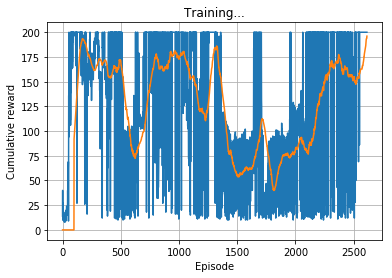

In [13]:
plot_rewards(cumulative_rewards)